The notebook is based on the article -> https://pygis.io/docs/e_interpolation.html

Interpolation is the process of using locations with known, sampled values (of a phenomenon) to estimate the values at unknown, unsampled areas. Here, we will explore two interpolation methods: Thiessen polygons (Voronoi diagrams) and k-nearest neighbors (KNN)

In [ ]:
!pip install osmnx
!pip install rasterio
!pip install pykrige
!pip install momepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 854.9/854.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 14.7 MB/s eta 0:00:00


# Libraries

In [ ]:
import osmnx as ox

import networkx as nx

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import geopandas as gpd
import numpy as np
import pandas as pd

# from pykrige.ok import OrdinaryKriging

import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine

from scipy.spatial import Voronoi, voronoi_plot_2d

from shapely.geometry import box
from shapely.geometry import Polygon, Point

# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.metrics import r2_score
# from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

import momepy
import urllib.request

In [ ]:
# Variables

crs = 3857 # mercator

# Data

In [ ]:
place_name= "Barcelona, Barcelonés, Barcelona, Catalonia, 08001, Spain" #taken from the NOMINATIM website
G = ox.graph_from_place(place_name, network_type='walk', simplify=True)
nodes, edges = ox.graph_to_gdfs(G)

In [ ]:
area = ox.geocode_to_gdf(place_name)
area

geometry  bbox_north  bbox_south  \
0  MULTIPOLYGON (((2.05250 41.42416, 2.05260 41.4...   41.467914   41.317035   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   2.228356   2.052498  103284126  relation  347950  41.382894  2.177432   

      class            type  place_rank  importance addresstype       name  \
0  boundary  administrative          16    0.743565        city  Barcelona   

                                        display_name  
0  Barcelona, Barcelonès, Barcelona, Catalonia, 0...

In [ ]:
G_proj = ox.projection.project_graph(G, to_crs=crs)
nodes, edges = ox.graph_to_gdfs(G_proj)
area = area.to_crs(epsg=crs)

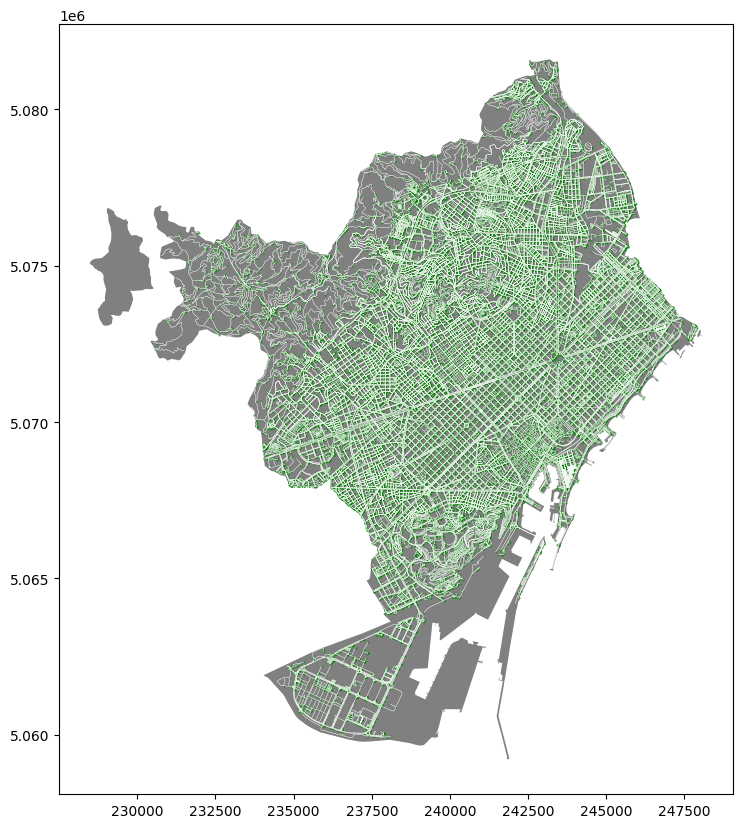

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
area.plot(ax=ax, facecolor='grey')
edges.plot(ax=ax, linewidth=0.2, edgecolor='white')
nodes.plot(ax=ax, color='green', markersize=.1)
plt.show()

## Loading the dataset
Let's use already familiar dataset and load it

In [ ]:
urllib.request.urlretrieve("https://opendata-ajuntament.barcelona.cat/data/dataset/d8f6af6e-e03e-462d-b3c8-d40b64179446/resource/7ba42e79-5682-474e-8488-a14cef22fb29/download/2019_tramer_no2_mapa_qualitat_aire_bcn.gpkg", 'file_2.gpkg')
url_no2='/content/file_2.gpkg'
streets = gpd.read_file(url_no2)
streets=streets.explode(index_parts=True)

In [ ]:
streets=ox.projection.project_gdf(streets, to_crs=crs, to_latlong=False)
streets

TRAM           Rang  \
0     0  T04719W  30 - 40 µg/m³   
1     0  T19941Z  30 - 40 µg/m³   
2     0  T18111R  30 - 40 µg/m³   
3     0  T03222Y  30 - 40 µg/m³   
4     0  T17625I  30 - 40 µg/m³   
...          ...            ...   
15036 0  T17103N  30 - 40 µg/m³   
15037 0  T07428A  30 - 40 µg/m³   
15038 0  T02455J  30 - 40 µg/m³   
15039 0  T08868Y  30 - 40 µg/m³   
15040 0  T05105C  30 - 40 µg/m³   

                                                  geometry  
0     0  LINESTRING (241005.181 5075648.455, 240941.246...  
1     0  LINESTRING (244632.461 5072252.979, 244721.167...  
2     0  LINESTRING (240616.473 5077752.840, 240653.822...  
3     0  LINESTRING (238041.630 5068080.934, 238042.865...  
4     0  LINESTRING (245971.584 5074566.632, 245870.548...  
...                                                    ...  
15036 0  LINESTRING (238144.659 5068544.729, 238241.165...  
15037 0  LINESTRING (237963.811 5069786.826, 237906.249...  
15038 0  LINESTRING (238505.469 5069157.551, 238544.143...  
15039 0  LINESTRING (243059.228 5073583.809, 243016.066...  
15040 0  LINESTRING (240361.527 5075391.880, 240283.618...  

[15041 rows x 3 columns]

## Transforming data

We will use the workflow for NO2 weights processing as in the previous notebook **"AIA24 - GraphML - Session 03 - 02 Open data"**

In [ ]:
weights_no2=streets.loc[:,"Rang"]
weights_no2=weights_no2.to_list()
print('Dataset length: ', len(weights_no2)) # one value per edge

no2_unique_values=list(streets.Rang.unique())
print('Unique values: ', no2_unique_values) # check the print

sorted_maximum_values=sorted([int(j[5:7]) if j[0] != "<" and j[0] != ">"  else int(j[3:5]) if j[0] == "<"  else int(j[2:4])+10 for j in no2_unique_values]) #notice that we added 10 to the case where > 70 µg/m³ to diffrentiat between it and '60 - 70 µg/m³'
print('Sorted values: ', sorted_maximum_values)

weights_dict={j:i for i,j in enumerate(sorted_maximum_values)}
print('Weights: ', weights_dict)

no2_modified_weights=[]

for i in weights_no2:
  if i[0] != "<" and i[0] != ">" :
    weight_value=weights_dict[int(i[5:7])]
  elif i[0] == "<":
    weight_value=weights_dict[int(i[3:5])]
  else:
    weight_value=weights_dict[int(i[2:4])+10]
  no2_modified_weights.append(weight_value)

# add the weights as a column in the geodataframe
streets['weight']=no2_modified_weights
# we add points to lines so we can use them for Voronoi later.
streets['centroid'] = streets['geometry'].centroid
streets['centroid'] = [Point(xy) for xy in zip(streets['centroid'].x, streets['centroid'].y)]

streets.head()

Dataset length:  15041
Unique values:  ['30 - 40 µg/m³', '20 - 30 µg/m³', '40 - 50 µg/m³', '50 - 60 µg/m³', '<= 20 µg/m³', '60 - 70 µg/m³', '> 70 µg/m³']
Sorted values:  [20, 30, 40, 50, 60, 70, 80]
Weights:  {20: 0, 30: 1, 40: 2, 50: 3, 60: 4, 70: 5, 80: 6}


TRAM           Rang  \
0 0  T04719W  30 - 40 µg/m³   
1 0  T19941Z  30 - 40 µg/m³   
2 0  T18111R  30 - 40 µg/m³   
3 0  T03222Y  30 - 40 µg/m³   
4 0  T17625I  30 - 40 µg/m³   

                                              geometry  weight  \
0 0  LINESTRING (241005.181 5075648.455, 240941.246...       2   
1 0  LINESTRING (244632.461 5072252.979, 244721.167...       2   
2 0  LINESTRING (240616.473 5077752.840, 240653.822...       2   
3 0  LINESTRING (238041.630 5068080.934, 238042.865...       2   
4 0  LINESTRING (245971.584 5074566.632, 245870.548...       2   

                                          centroid  
0 0  POINT (240973.21333519666 5075653.8327680575)  
1 0   POINT (244676.81397409787 5072215.361890579)  
2 0    POINT (240664.43191767525 5077776.06859397)  
3 0   POINT (238042.24767221982 5068132.620262206)  
4 0   POINT (245921.0661089208 5074617.7317677755)

Now we have point as a geometry

In [ ]:
centroids_and_weights_gdf = gpd.GeoDataFrame(streets, geometry='centroid', crs=crs)
centroids_and_weights_gdf = centroids_and_weights_gdf.drop(columns=['geometry', 'TRAM', 'Rang'])
centroids_and_weights_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 15041 entries, (0, 0) to (15040, 0)
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   weight    15041 non-null  int64   
 1   centroid  15041 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 912.8 KB


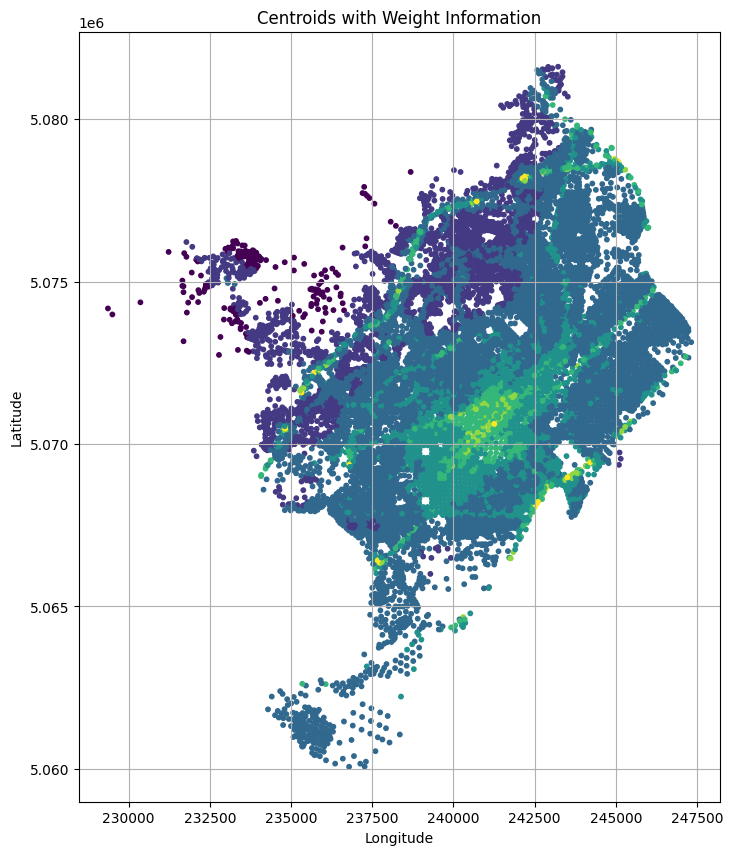

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
centroids_and_weights_gdf.plot(ax=ax, column='weight', cmap='viridis', markersize=10, aspect='equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Centroids with Weight Information')
plt.grid(True)
plt.show()

The dataset is quite large. To enhance clarity, we'll utilize only 0.5% of the data points. We'll randomly select a portion of the dataset for further analysis. Let's filter out some points to proceed with the next steps.

In [ ]:
n_nodes_to_keep = int(len(centroids_and_weights_gdf) * 0.005) # here we pick 0.5% of dataset
centroids_and_weights_gdf_sampled = centroids_and_weights_gdf.sample(n=n_nodes_to_keep, random_state=42) # sample random points
centroids_and_weights_gdf_sampled.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 75 entries, (13314, 0) to (7276, 0)
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   weight    75 non-null     int64   
 1   centroid  75 non-null     geometry
dtypes: geometry(1), int64(1)
memory usage: 635.1 KB


Now, let's take a look at the remaining data points.

In [ ]:
centroids_and_weights_gdf_sampled['weight'].unique()

array([3, 2, 1, 5, 0, 4])

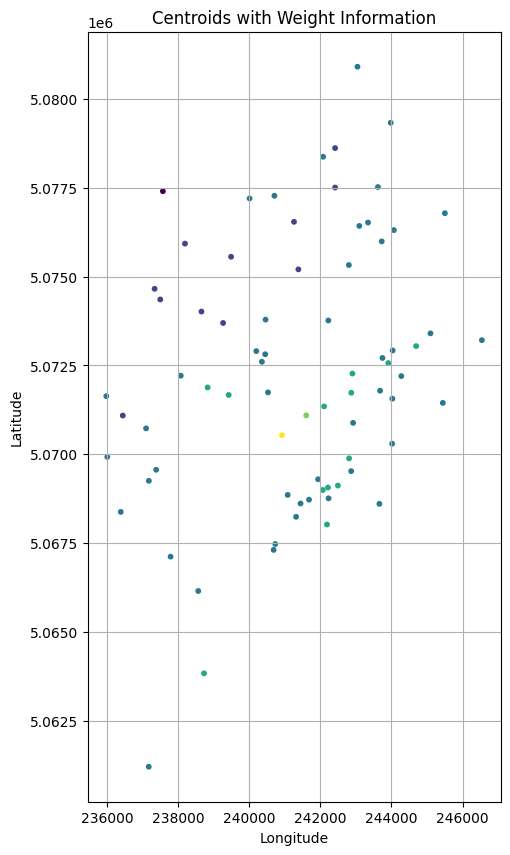

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
centroids_and_weights_gdf_sampled.plot(ax=ax, column='weight', cmap='viridis', markersize=10, aspect='equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Centroids with Weight Information')
plt.grid(True)
plt.show()

We print the points on the map to review them. To control the plot order, we use `zorder` parameter.

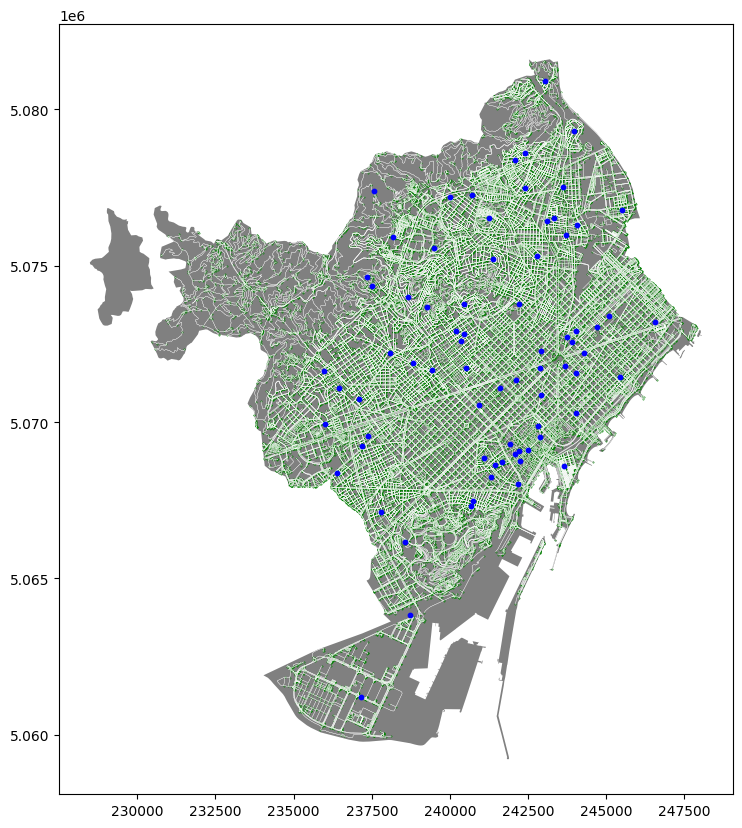

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
area.plot(ax=ax, facecolor='grey')
edges.plot(ax=ax, linewidth=0.2, edgecolor='white')
nodes.plot(ax=ax, color='green', markersize=.1)
centroids_and_weights_gdf_sampled.plot(ax=ax, color='blue', markersize=10, zorder=4) # zorder to control the order of layouts

plt.show()

# Voronoi

The `.buffer()` method generates a buffer area around each geometry in the GeoDataFrame. The buffer extends outward (or inward if the value is negative) by a specified distance.

In [ ]:
# Extend extent of area buffer by using buffer
area_buffer = area.buffer(1000)
area_buffer

0    POLYGON ((227754.160 5075792.396, 227835.078 5...
dtype: geometry

`.total_bounds` attribute returns the extent of the entire GeoDataFrame in the form of a tuple containing the minimum and maximum coordinates for both x and y directions. The structure is: `(min_x, min_y, max_x, max_y)`.
These coordinates represent a rectangular bounding box that fully contains all geometries within the GeoDataFrame.

In [ ]:
# Get extent of buffered area feature
min_x_area, min_y_area, max_x_area, max_y_area = area_buffer.total_bounds
min_x_area, min_y_area, max_x_area, max_y_area

(227483.00111302646, 5058217.655137442, 249058.79801105615, 5082605.667297152)

Using `.geometry.apply(lambda point: (point.x, point.y))`, we are extracting the x and y coordinates from each point geometry in the GeoDataFrame.
This results in a list of tuples, where each tuple represents a centroid's `x` and `y` coordinates.

`coords_area` is a list containing four points that form the corners of the bounding box around the buffered area.

In [ ]:
# Create dummy points for Voronoi calculation
coords_centroids_and_weights_gdf_sampled = list(centroids_and_weights_gdf_sampled.geometry.apply(lambda point: (point.x, point.y)))
coords_area = [[min_x_area, min_y_area], [max_x_area, min_y_area], [max_x_area, max_y_area], [min_x_area, max_y_area]]
print(coords_centroids_and_weights_gdf_sampled[:5]) # slice of first 5 items
print(coords_area)

[(244693.52628888696, 5073043.309221541), (242807.8233120208, 5069884.089953975), (241079.55160750682, 5068855.500574732), (238726.61057473853, 5063835.561644009), (241380.188937963, 5075202.154863354)]
[[227483.00111302646, 5058217.655137442], [249058.79801105615, 5058217.655137442], [249058.79801105615, 5082605.667297152], [227483.00111302646, 5082605.667297152]]


In [ ]:
#combine NO2 points and extent points
coords_combined = coords_centroids_and_weights_gdf_sampled + coords_area
coords_combined[:5] # slice of first 5 items

[(244693.52628888696, 5073043.309221541),
 (242807.8233120208, 5069884.089953975),
 (241079.55160750682, 5068855.500574732),
 (238726.61057473853, 5063835.561644009),
 (241380.188937963, 5075202.154863354)]

Now our list combines both sampled NO2 measurement points and additional boundary points that define the rectangular extent of the area. The `Voronoi` class from the `scipy.spatial` module takes these coordinates and computes the Voronoi diagram.
A `Voronoi` diagram divides the 2D space into regions based on distances to each point (or seed). Each region consists of all locations that are closest to a particular seed point compared to any other seed point.
The result is a collection of polygons that represent regions of influence around each point.

In [ ]:
vor = Voronoi(coords_combined)
#check info
print(vor.regions[:10])
print(vor.vertices[:10])

[[], [6, 2, -1, 1, 5], [14, 7, 2, -1, 3, 4, 13], [20, 8, 0, -1, 3, 19], [24, 1, 5, 11, 22], [25, 17, 18, 16, 0, -1, 1, 24], [30, 10, 9, 29], [31, 12, 14, 7, 10, 30], [36, 34, 35], [40, 15, 36, 35, 37]]
[[ 275810.06179587 5070411.6612173 ]
 [ 238270.89956204 5040450.42874493]
 [ 223030.99672198 5070411.6612173 ]
 [ 238270.89956204 5109261.54912958]
 [ 235756.39819887 5086265.30608391]
 [ 230956.17520722 5064152.71669909]
 [ 227639.97590875 5067057.41600734]
 [ 223271.73650926 5070573.41473176]
 [ 252080.63371291 5076762.62795544]
 [ 236489.82279175 5070406.21113002]]


In [ ]:
vor_poly_list = []

# creating a polygon for each region
for region in vor.regions:
    if -1 in region or len(region) == 0: # ignore region if -1 is in the list
        continue
    vor_poly_region = Polygon([vor.vertices[i] for i in region]) # create polygon using region vertices
    vor_poly_list.append(vor_poly_region)

vor_polys = gpd.GeoDataFrame(vor_poly_list, columns=['geometry'], crs=area.crs)

`vor_polys_clipped = gpd.clip(vor_polys, area)` performs a spatial "clipping" operation:
The clip function ensures that the polygons are only included or displayed within a specific boundary, as defined by the area GeoDataFrame.
The polygons extending beyond this boundary will be cut off at the boundary, ensuring that all the Voronoi polygons are strictly within the desired area.

In [ ]:
vor_polys_clipped = gpd.clip(vor_polys, area) # clip polygon regions to the area boundary
vor_polys_clipped

geometry
0   MULTIPOLYGON (((238784.653 5062026.040, 238745...
15  MULTIPOLYGON (((241546.176 5060390.591, 241493...
13  POLYGON ((237351.664 5064901.984, 237333.188 5...
12  POLYGON ((237475.178 5068183.863, 238624.642 5...
7   POLYGON ((236359.669 5069192.092, 237475.178 5...
..                                                ...
59  POLYGON ((242183.406 5076604.872, 241565.543 5...
26  POLYGON ((241523.405 5077655.864, 241565.543 5...
21  POLYGON ((243409.976 5078499.999, 243010.054 5...
28  POLYGON ((242556.988 5078059.733, 241523.405 5...
29  POLYGON ((242852.413 5079725.299, 241106.337 5...

[75 rows x 1 columns]

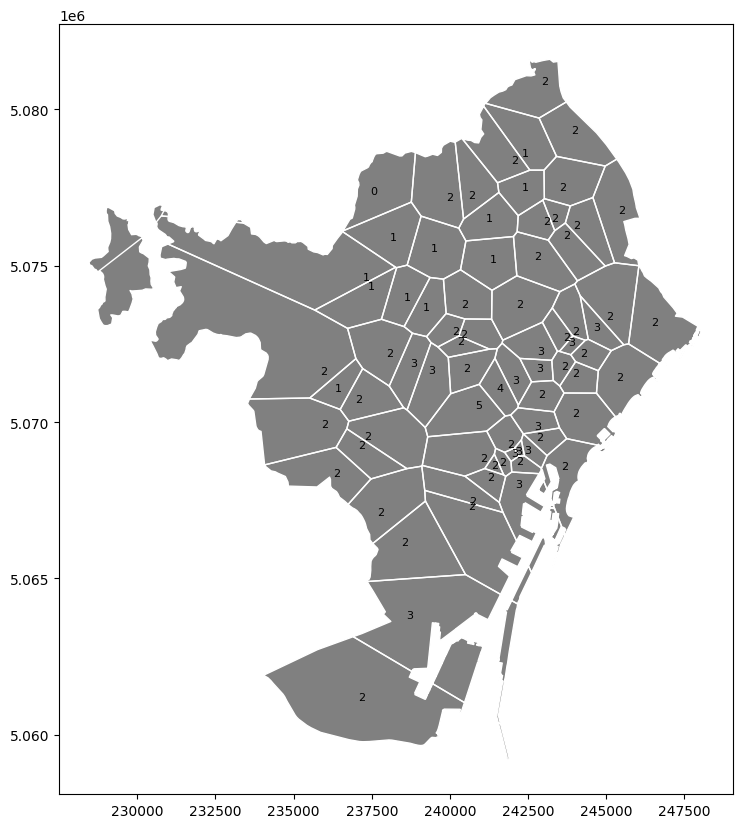

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

area.plot(ax=ax, facecolor='grey')
vor_polys_clipped.plot(ax=ax, facecolor='none', edgecolor='white')
# the numbers represent weights from gdf
for idx, row in centroids_and_weights_gdf_sampled.iterrows():
    centroid = row.centroid
    weight = row['weight']
    ax.text(centroid.x, centroid.y, f'{weight}', fontsize=8, ha='center', va='center', color='black')

plt.show()

Here we add `NO2_Weights` to polygons.

In [ ]:
vor_polys_with_weights = gpd.sjoin(vor_polys_clipped, centroids_and_weights_gdf_sampled, how="inner", op='intersects')
vor_polys_with_weights = vor_polys_with_weights.rename(columns={'weight': 'NO2_Weight'})
vor_polys_with_weights

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


geometry  index_right0  \
0   MULTIPOLYGON (((238784.653 5062026.040, 238745...          7306   
15  MULTIPOLYGON (((241546.176 5060390.591, 241493...          4990   
13  POLYGON ((237351.664 5064901.984, 237333.188 5...          3087   
12  POLYGON ((237475.178 5068183.863, 238624.642 5...          9081   
7   POLYGON ((236359.669 5069192.092, 237475.178 5...         10994   
..                                                ...           ...   
59  POLYGON ((242183.406 5076604.872, 241565.543 5...          8183   
26  POLYGON ((241523.405 5077655.864, 241565.543 5...         10792   
21  POLYGON ((243409.976 5078499.999, 243010.054 5...         11753   
28  POLYGON ((242556.988 5078059.733, 241523.405 5...         13731   
29  POLYGON ((242852.413 5079725.299, 241106.337 5...          2802   

    index_right1  NO2_Weight  
0              0           2  
15             0           3  
13             0           2  
12             0           2  
7              0           2  
..           ...         ...  
59             0           1  
26             0           2  
21             0           1  
28             0           2  
29             0           2  

[75 rows x 4 columns]

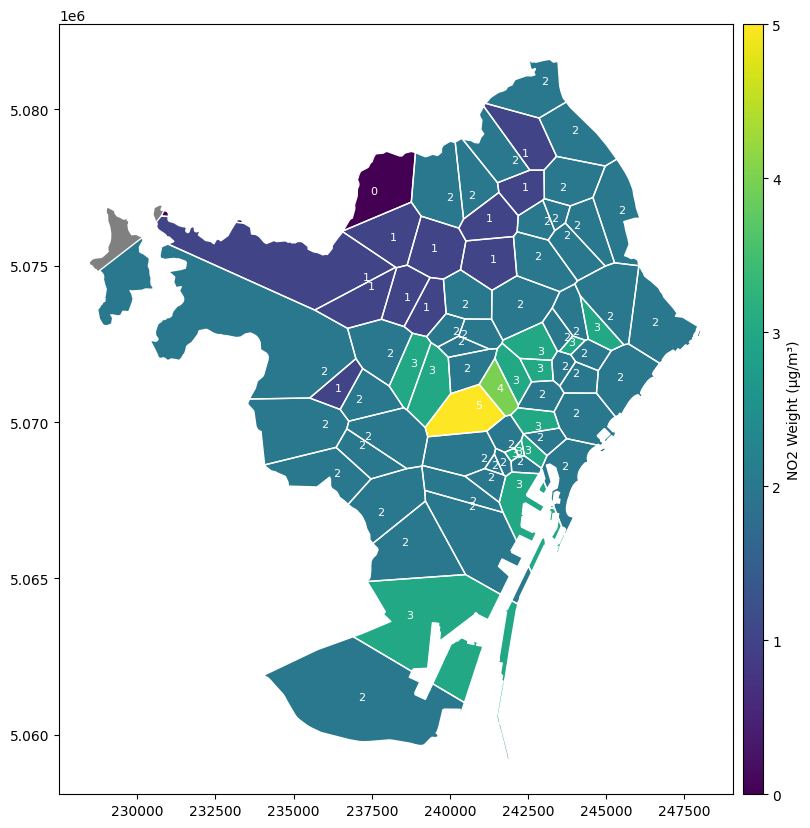

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

area.plot(ax=ax, facecolor='grey')
polygon_plot = vor_polys_with_weights.plot(ax=ax, column='NO2_Weight', cmap='viridis', legend=False)
vor_polys_clipped.plot(ax=ax, facecolor='none', edgecolor='white')

for idx, row in centroids_and_weights_gdf_sampled.iterrows():
    centroid = row.centroid
    weight = row['weight']
    ax.text(centroid.x, centroid.y, f'{weight}', fontsize=8, ha='center', va='center', color='white')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)

sm1 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vor_polys_with_weights['NO2_Weight'].min(), vor_polys_with_weights['NO2_Weight'].max()))
cbar1 = fig.colorbar(sm1, cax=cax1)
cbar1.set_label('NO2 Weight (µg/m³)')

plt.show()

Assigning test nodes the `NO2 weight` from its encompassing Voronoi polygon.

In [ ]:
nodes_by_voronoy = gpd.sjoin(nodes, vor_polys_with_weights, how="left", op='within') # assign each test node the NO2 weight from its encompassing Voronoi polygon
nodes_by_voronoy.head()

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


y              x  street_count       lon        lat  \
osmid                                                                        
21638843    5.067125e+06  243521.749955             3  2.187593  41.370365   
6831738685  5.067113e+06  243525.512554             4  2.187627  41.370285   
8462014250  5.067126e+06  243516.028133             4  2.187542  41.370370   
6831706284  5.067200e+06  243529.909674             4  2.187666  41.370875   
21638845    5.067084e+06  243538.436747             3  2.187743  41.370092   

             highway  ref                        geometry  index_right  \
osmid                                                                    
21638843         NaN  NaN  POINT (243521.750 5067124.816)         56.0   
6831738685  crossing  NaN  POINT (243525.513 5067112.935)         56.0   
8462014250       NaN  NaN  POINT (243516.028 5067125.573)         56.0   
6831706284  crossing  NaN  POINT (243529.910 5067200.483)         56.0   
21638845         NaN  NaN  POINT (243538.437 5067084.439)         56.0   

            index_right0  index_right1  NO2_Weight  
osmid                                               
21638843          2325.0           0.0         2.0  
6831738685        2325.0           0.0         2.0  
8462014250        2325.0           0.0         2.0  
6831706284        2325.0           0.0         2.0  
21638845          2325.0           0.0         2.0

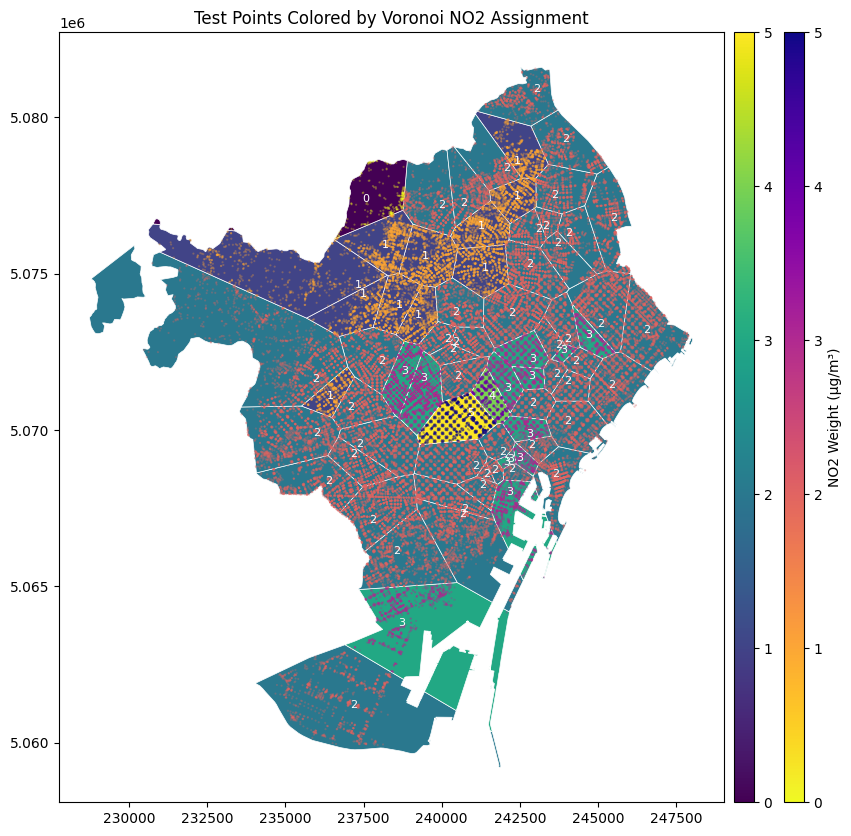

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

vor_polys_with_weights.plot(column='NO2_Weight', cmap='viridis', linewidth=0.5, edgecolor='white', ax=ax, legend=False)
nodes_by_voronoy.plot(column='NO2_Weight', cmap='plasma_r', markersize=0.3, ax=ax, legend=False, alpha=0.3)

for idx, row in centroids_and_weights_gdf_sampled.iterrows():
    centroid = row.centroid
    weight = row['weight']
    ax.text(centroid.x, centroid.y, f'{weight}', fontsize=8, ha='center', va='center', color='white')

ax.set_title('Test Points Colored by Voronoi NO2 Assignment')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)

sm1 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vor_polys_with_weights['NO2_Weight'].min(), vor_polys_with_weights['NO2_Weight'].max()))
cbar1 = fig.colorbar(sm1, cax=cax1)

cax2 = divider.append_axes("right", size="3%", pad=0.3)

sm2 = plt.cm.ScalarMappable(cmap='plasma_r', norm=plt.Normalize(vor_polys_with_weights['NO2_Weight'].min(), vor_polys_with_weights['NO2_Weight'].max()))
cbar2 = fig.colorbar(sm2, cax=cax2)
cbar2.set_label('NO2 Weight (µg/m³)')

plt.show()

# K-Nearest Neighbors

More information about KNN could be found here -> https://scikit-learn.org/stable/modules/neighbors.html

Article about KNN -> https://python.plainenglish.io/hands-on-k-nearest-neighbors-knn-algorithm-with-python-a6ed65f94e75

**KNN Regressor vs. KNN Classifier**

**KNN Regressor:**

- Purpose: Predicts a continuous numerical value for a given input.
- How It Works: Finds the k-nearest neighbors of the input and calculates the average of their values to make the prediction.
- Example Use Case: Predicting the price of a house based on its features (e.g., size, location, number of bedrooms).

**KNN Classifier:**

- Purpose: Predicts a categorical label for a given input.
- How It Works: Finds the k-nearest neighbors of the input and assigns the most common label among them as the prediction.
- Example Use Case: Classifying an email as spam or not spam based on its content.

**Key Differences:**
- Output Type: KNN Regressor outputs a <font color= "orange" >**numerical value**<font color= "white" >, while KNN Classifier outputs a <font color= "orange" >**categorical label**.<font color= "white" >
- Aggregation Method: KNN Regressor uses averaging of neighbor values, whereas KNN Classifier uses majority voting among neighbor labels.

## K-Nearest Neighbors Classification

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

First, we will extract the data for training and testing. The training data will be the labeled set that we will show our algorithm, while the testing data will be the set we use to have the pre-trained algorithm make predictions.

In [ ]:
# we use sampled data set `centroids_and_weights_gdf_sampled` as a training dataset

train_coords = list(centroids_and_weights_gdf_sampled.geometry.apply(lambda p: (p.x, p.y))) # extract coordinates (features) and NO2 weights (target values) from the training dataset
train_values = centroids_and_weights_gdf_sampled['weight'].values
print(train_coords[:5])
print(train_values[:5])

[(244693.52628888696, 5073043.309221541), (242807.8233120208, 5069884.089953975), (241079.55160750682, 5068855.500574732), (238726.61057473853, 5063835.561644009), (241380.188937963, 5075202.154863354)]
[3 3 2 3 1]


In [ ]:
test_coords = list(nodes.geometry.apply(lambda p: (p.x, p.y))) # extract the coordinates from the test nodes dataset (nodes)
print(test_coords[:5])

[(243521.7499548788, 5067124.81631219), (243525.51255366762, 5067112.934574811), (243516.02813305205, 5067125.5728278), (243529.90967355395, 5067200.483000457), (243538.43674654872, 5067084.439231791)]


In the context of the k-Nearest Neighbors (k-NN) algorithm, setting the neighbors parameter (often referred to as k) determines how many nearest neighbors the algorithm will consider when making predictions. Here's how it impacts the algorithm:

1. Classification (our case): If you're using k-NN for classification tasks, the algorithm will:

 - Find the k closest data points (neighbors) to a query point based on a distance metric (e.g., Euclidean distance).
 - Count the frequency of each class label among these neighbors.
 - Assign the majority class label to the query point.
For instance, if k=5, and three neighbors belong to class A while two belong to class B, the query point will be classified as class A.

2. Regression: If you're using k-NN for regression tasks, the algorithm will:

 - Find the k nearest neighbors to the query point.
 - Take the average (or weighted average) of their target values.
 - Use this average to predict the target value for the query point.

**Impact of the k Parameter:**
- Small k (e.g., k = 1): The algorithm becomes more sensitive to noise and outliers, as it only considers very close points, potentially leading to overfitting.
- Large k (e.g., k = 20 or more): The algorithm becomes more stable but might underfit, as distant points influence predictions.

Finding the optimal value of k usually involves testing different values using a validation set or techniques like cross-validation.

In [ ]:
# k
neighbors = 5

More information about KNN_Classifier could be found here -> https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

In [ ]:
# initialize the KNN classifier, here we use KNeighborsClassifier from scikit-learn
knn_classifier = KNeighborsClassifier(n_neighbors=neighbors, weights='distance')

# fit the classifier train data, that in our case is `centroids_and_weights_gdf`
knn_classifier.fit(train_coords, train_values)

# predict the values for the testing dataset, that are graph `nodes`
predicted_values_knn = knn_classifier.predict(test_coords)

In [ ]:
# create df with the original coordinates and the predicted values
predict_df_knn = pd.DataFrame({'Coordinate_Pair': test_coords, 'NO2_Predicted': predicted_values_knn})

# convert to gdf
predict_gdf_knn = gpd.GeoDataFrame(predict_df_knn, geometry=gpd.points_from_xy(
    [coord[0] for coord in predict_df_knn['Coordinate_Pair']],
    [coord[1] for coord in predict_df_knn['Coordinate_Pair']]
),crs=nodes.crs)

predict_gdf_knn.head()

Coordinate_Pair  NO2_Predicted  \
0    (243521.7499548788, 5067124.81631219)              3   
1  (243525.51255366762, 5067112.934574811)              3   
2    (243516.02813305205, 5067125.5728278)              3   
3  (243529.90967355395, 5067200.483000457)              3   
4  (243538.43674654872, 5067084.439231791)              3   

                         geometry  
0  POINT (243521.750 5067124.816)  
1  POINT (243525.513 5067112.935)  
2  POINT (243516.028 5067125.573)  
3  POINT (243529.910 5067200.483)  
4  POINT (243538.437 5067084.439)

Here, we have our unique classes of NO2 applied to the nodes GeoDataFrame from the graph.

In [ ]:
predict_df_knn['NO2_Predicted'].unique()

array([3, 2, 5, 4, 1, 0])

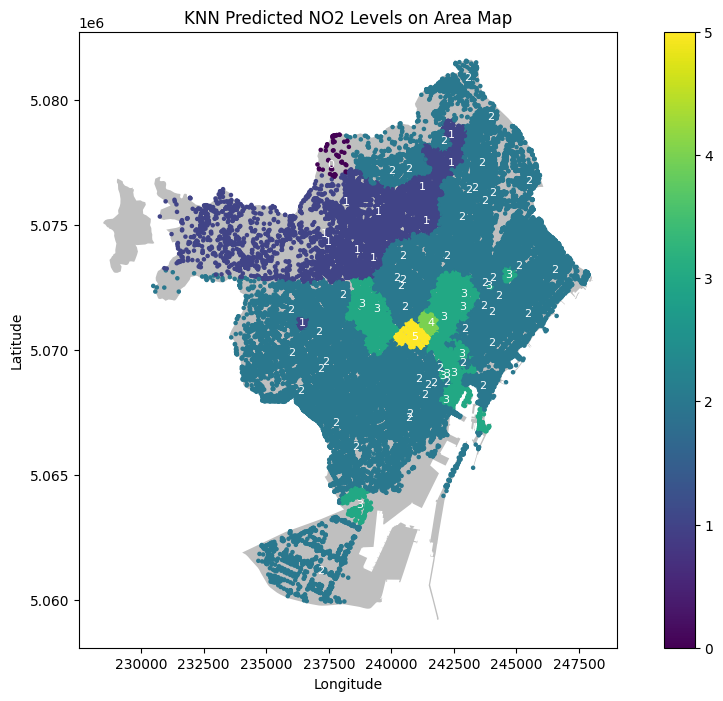

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
area.plot(ax=ax, facecolor='grey', alpha=0.5)

predict_gdf_knn.plot(column='NO2_Predicted', cmap='viridis', markersize=5, ax=ax, legend=True)

for idx, row in centroids_and_weights_gdf_sampled.iterrows():
    centroid = row.centroid
    weight = row['weight']
    ax.text(centroid.x, centroid.y, f'{weight}', fontsize=8, ha='center', va='center', color='white')

ax.set_title('KNN Predicted NO2 Levels on Area Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

We can compare the plot with given data and predicted one.

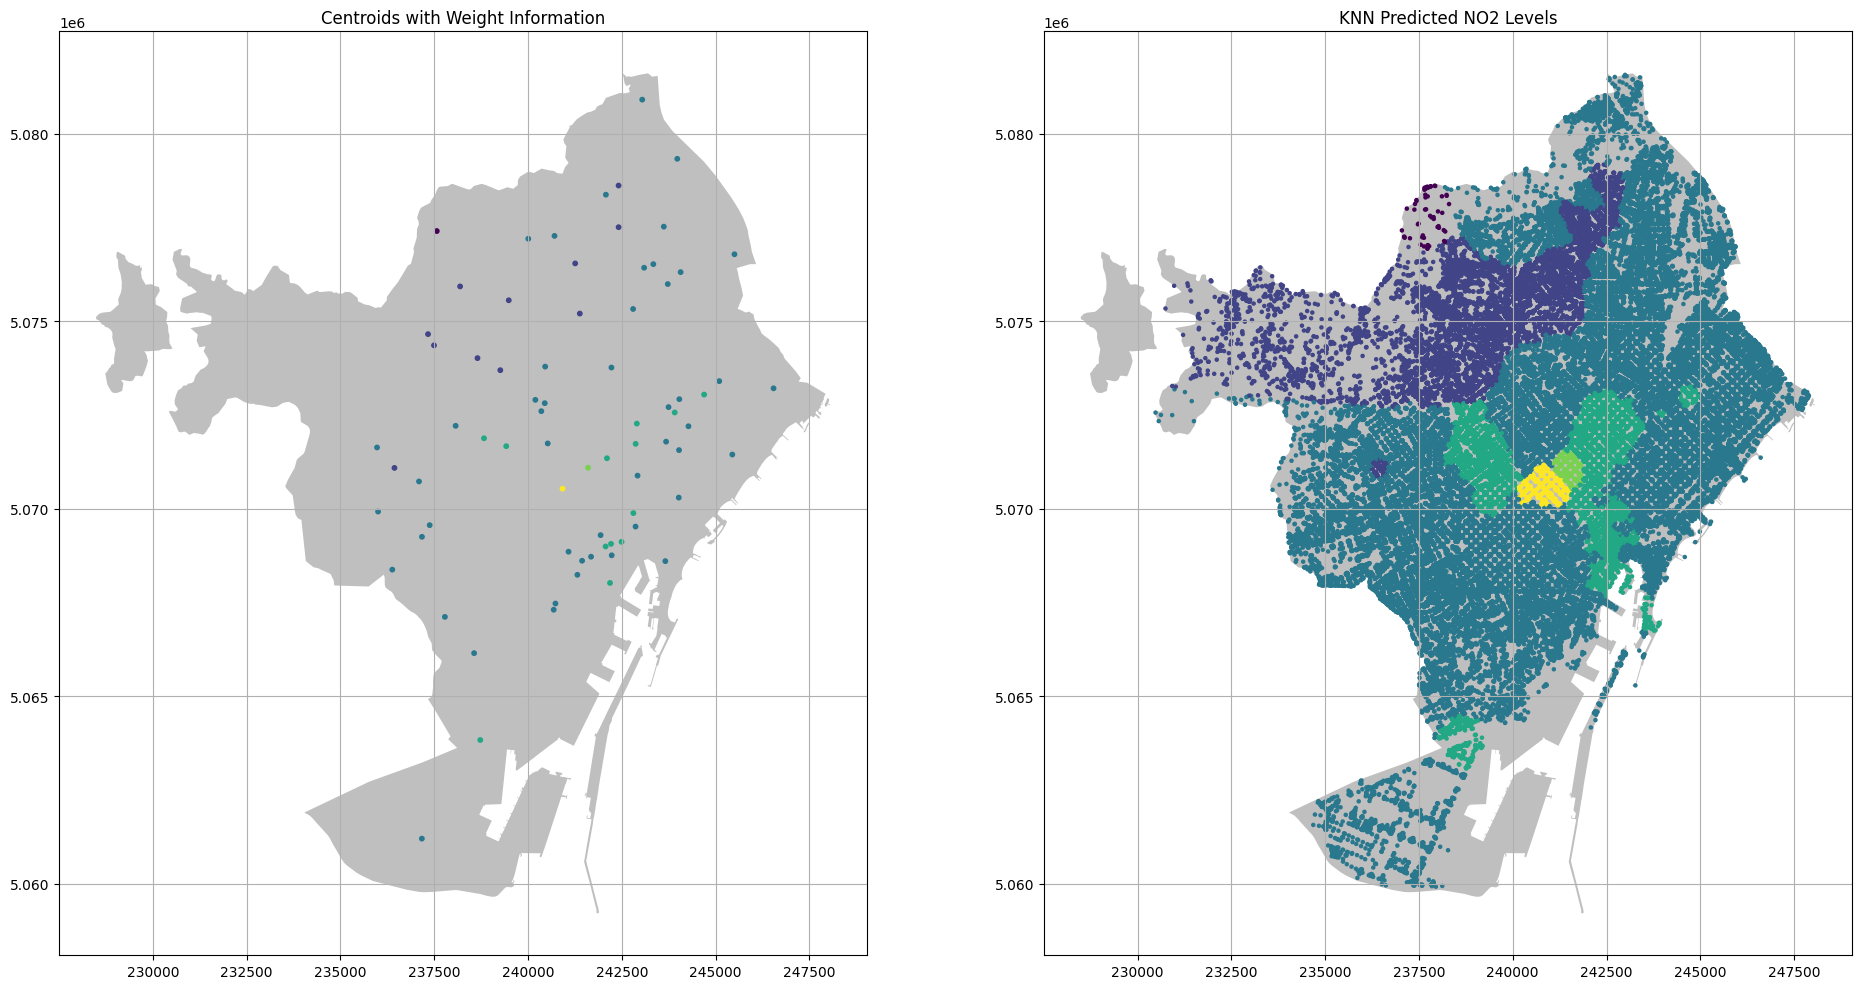

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# first plot - Centroids with Weight Information
area.plot(ax=axes[0], facecolor='grey', alpha=0.5)
centroids_and_weights_gdf_sampled.plot(
    ax=axes[0],
    column='weight',
    cmap='viridis',
    markersize=10,
    aspect='equal',
    legend=False
)
axes[0].set_title('Centroids with Weight Information')
axes[0].grid(True)

# second plot - KNN Predicted NO2 Levels on Area Map
area.plot(ax=axes[1], facecolor='grey', alpha=0.5)
predict_gdf_knn.plot(
    column='NO2_Predicted',
    cmap='viridis',
    markersize=5,
    ax=axes[1],
    legend=False
)
axes[1].set_title('KNN Predicted NO2 Levels')
axes[1].grid(True)

plt.tight_layout()
plt.show()

And finally, let's train on all (100%) of the points in the dataset `centroids_and_weights_gdf`. We'll repeat the same process, only changing the training dataset.

You could also try different options for the number of nodes you keep available for training and see how the results change. To use only a percentage of the points, please utilize code similar to that above.

```
n_nodes_to_keep = int(len(centroids_and_weights_gdf) * 0.005) # here we pick 0.5% of dataset
centroids_and_weights_gdf_sampled = centroids_and_weights_gdf.sample(n=n_nodes_to_keep, random_state=42) # sample random points
```



[(240973.21333519666, 5075653.8327680575), (244676.81397409787, 5072215.361890579), (240664.43191767525, 5077776.06859397), (238042.24767221982, 5068132.620262206), (245921.0661089208, 5074617.7317677755)]
[2 2 2 2 2]
[(243521.7499548788, 5067124.81631219), (243525.51255366762, 5067112.934574811), (243516.02813305205, 5067125.5728278), (243529.90967355395, 5067200.483000457), (243538.43674654872, 5067084.439231791)]


Coordinate_Pair  NO2_Predicted  \
0    (243521.7499548788, 5067124.81631219)              2   
1  (243525.51255366762, 5067112.934574811)              2   
2    (243516.02813305205, 5067125.5728278)              2   
3  (243529.90967355395, 5067200.483000457)              2   
4  (243538.43674654872, 5067084.439231791)              2   

                         geometry  
0  POINT (243521.750 5067124.816)  
1  POINT (243525.513 5067112.935)  
2  POINT (243516.028 5067125.573)  
3  POINT (243529.910 5067200.483)  
4  POINT (243538.437 5067084.439)

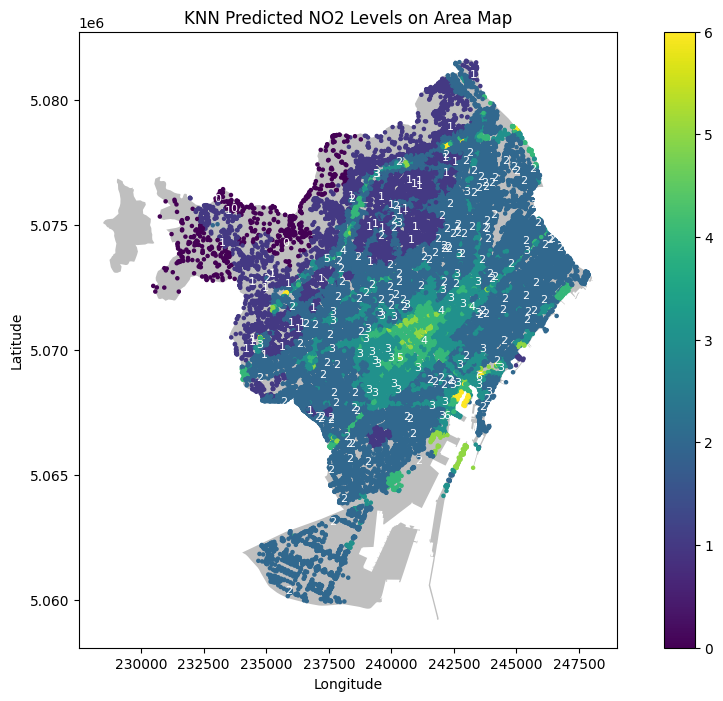

In [ ]:
# here we use all points from `centroids_and_weights_gdf` for training our KNN

train_coords = list(centroids_and_weights_gdf.geometry.apply(lambda p: (p.x, p.y))) # extract coordinates (features) and NO2 weights (target values) from the training dataset
train_values = centroids_and_weights_gdf['weight'].values
print(train_coords[:5])
print(train_values[:5])

test_coords = list(nodes.geometry.apply(lambda p: (p.x, p.y))) # extract the coordinates from the test nodes dataset (nodes)
print(test_coords[:5])

# k
neighbors = 5

# initialize the KNN classifier, here we use KNeighborsClassifier from scikit-learn
knn_classifier = KNeighborsClassifier(n_neighbors=neighbors, weights='distance')

# fit the classifier train data, that in our case is `centroids_and_weights_gdf`
knn_classifier.fit(train_coords, train_values)

# predict the values for the testing dataset, that are graph `nodes`
predicted_values_knn = knn_classifier.predict(test_coords)

# create df with the original coordinates and the predicted values
predict_df_knn = pd.DataFrame({'Coordinate_Pair': test_coords, 'NO2_Predicted': predicted_values_knn})

# convert to gdf
predict_gdf_knn = gpd.GeoDataFrame(predict_df_knn, geometry=gpd.points_from_xy(
    [coord[0] for coord in predict_df_knn['Coordinate_Pair']],
    [coord[1] for coord in predict_df_knn['Coordinate_Pair']]
),crs=nodes.crs)

display(predict_gdf_knn.head())

# plotting
fig, ax = plt.subplots(figsize=(12, 8))
area.plot(ax=ax, facecolor='grey', alpha=0.5)

predict_gdf_knn.plot(column='NO2_Predicted', cmap='viridis', markersize=5, ax=ax, legend=True)

# here, we're showing the numbers for 1,5% of the points in our dataset for better visualization.
# you can manipulate numbers by changing `sampling_fraction` parameter.
sampling_fraction = 0.015
sampled_points = centroids_and_weights_gdf.sample(frac=sampling_fraction)
for idx, row in sampled_points.iterrows():
    centroid = row.centroid
    weight = row['weight']
    ax.text(centroid.x, centroid.y, f'{weight}', fontsize=8, ha='center', va='center', color='white')

ax.set_title('KNN Predicted NO2 Levels on Area Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

Let`s compare the plot with given data and predicted one.

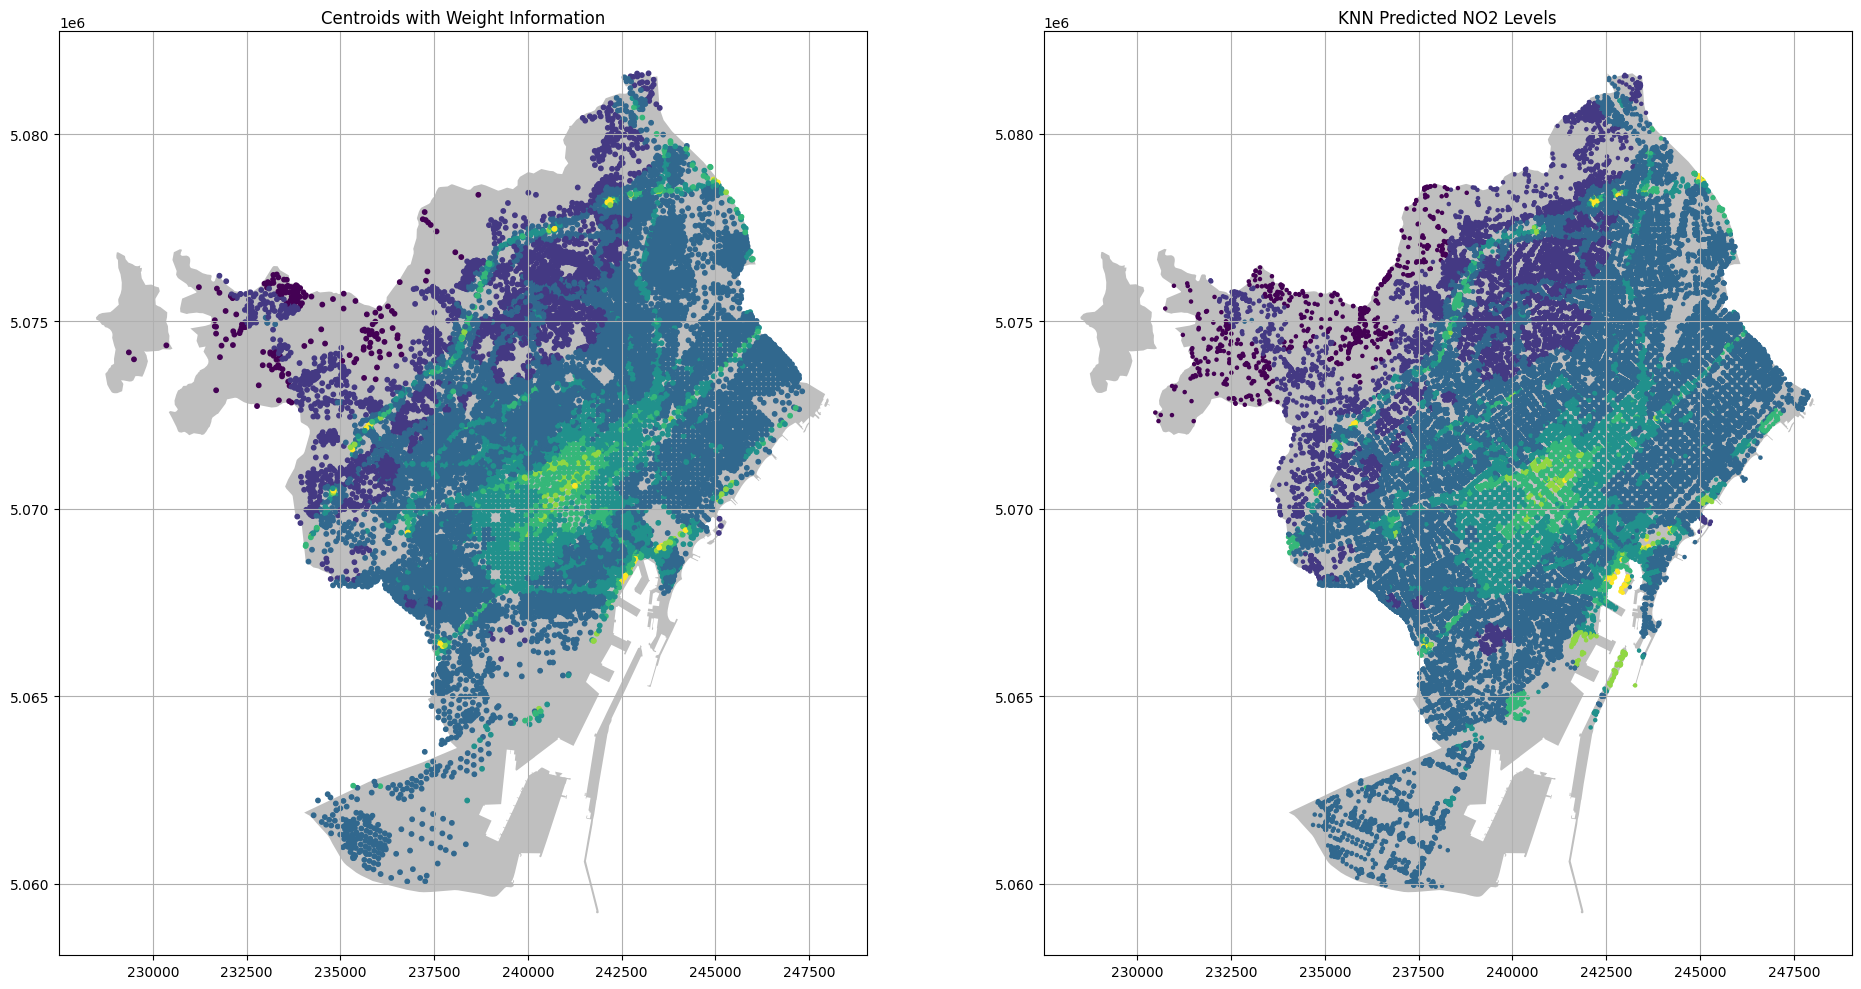

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# first plot - Centroids with Weight Information
area.plot(ax=axes[0], facecolor='grey', alpha=0.5)
centroids_and_weights_gdf.plot(
    ax=axes[0],
    column='weight',
    cmap='viridis',
    markersize=10,
    aspect='equal',
    legend=False
)
axes[0].set_title('Centroids with Weight Information')
axes[0].grid(True)

# second plot - KNN Predicted NO2 Levels on Area Map
area.plot(ax=axes[1], facecolor='grey', alpha=0.5)
predict_gdf_knn.plot(
    column='NO2_Predicted',
    cmap='viridis',
    markersize=5,
    ax=axes[1],
    legend=False
)
axes[1].set_title('KNN Predicted NO2 Levels')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Article about KNN -> https://python.plainenglish.io/hands-on-k-nearest-neighbors-knn-algorithm-with-python-a6ed65f94e75

### Summary for KNN_Classification

**Coordinates Extraction:**

- train_coords and train_values store the features (coordinates) and labels (NO2 weight) from the training dataset.
- test_coords extracts the coordinates from the test dataset.

**KNeighborsClassifier Initialization:**

- Initialize a KNeighborsClassifier instance with n_neighbors=5 (k=5) and weights='distance'.
- The weights='distance' parameter ensures that closer neighbors have a stronger influence on the classification or prediction.

**Model Fitting:**

- The classifier is fitted with train_coords as features and train_values as target values.

**Prediction:**

- The predict function is called on test_coords, which contains coordinates from the nodes dataset.
- For each point in test_coords, the classifier searches the training dataset to find the five nearest neighbors based on the geographical coordinates (latitude and longitude).
- It then uses these five neighbors' known labels to predict the class or value of the test point.

**Creating Predicted GeoDataFrame:**

- A DataFrame is created that associates each test point’s coordinates with its predicted NO2 weight/class.
- The DataFrame is converted into a GeoDataFrame using geopandas.

**Important Points to Remember:**
- The k-NN algorithm is a lazy learner, meaning it does not build a model in advance. Instead, it uses the training data directly to classify/predict each test point during evaluation.
- The k-NN algorithm can become slow with large datasets since it involves calculating distances for each test point across the entire training dataset.

## K-Nearest Neighbors Regression

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

To explore KNN regression, we are going to go back to the sampled dataset and consider our **categories as numeric data**.

In [ ]:
# we use sampled data set `centroids_and_weights_gdf_sampled` as a training dataset

train_coords = list(centroids_and_weights_gdf_sampled.geometry.apply(lambda p: (p.x, p.y))) # extract coordinates (features) and NO2 weights (target values) from the training dataset
train_values = centroids_and_weights_gdf_sampled['weight'].values
print(train_coords[:5])
print(train_values[:5])

[(244693.52628888696, 5073043.309221541), (242807.8233120208, 5069884.089953975), (241079.55160750682, 5068855.500574732), (238726.61057473853, 5063835.561644009), (241380.188937963, 5075202.154863354)]
[3 3 2 3 1]


In [ ]:
test_coords = list(nodes.geometry.apply(lambda p: (p.x, p.y))) # extract the coordinates from the test nodes dataset (nodes)
print(test_coords[:5])

[(243521.7499548788, 5067124.81631219), (243525.51255366762, 5067112.934574811), (243516.02813305205, 5067125.5728278), (243529.90967355395, 5067200.483000457), (243538.43674654872, 5067084.439231791)]


**Weighted Mean:** When `weights='distance'` is used, the KNN regressor calculates the predicted value as a weighted average of the values of the k-nearest neighbors. Closer neighbors have a larger influence on the predicted value.

Have a look at the numbers that were applied in NO2_predicted; they are not classes, but continuous data.


Coordinate_Pair  NO2_Predicted  \
0    (243521.7499548788, 5067124.81631219)       2.564422   
1  (243525.51255366762, 5067112.934574811)       2.564722   
2    (243516.02813305205, 5067125.5728278)       2.564750   
3  (243529.90967355395, 5067200.483000457)       2.560208   
4  (243538.43674654872, 5067084.439231791)       2.565188   

                         geometry  
0  POINT (243521.750 5067124.816)  
1  POINT (243525.513 5067112.935)  
2  POINT (243516.028 5067125.573)  
3  POINT (243529.910 5067200.483)  
4  POINT (243538.437 5067084.439)

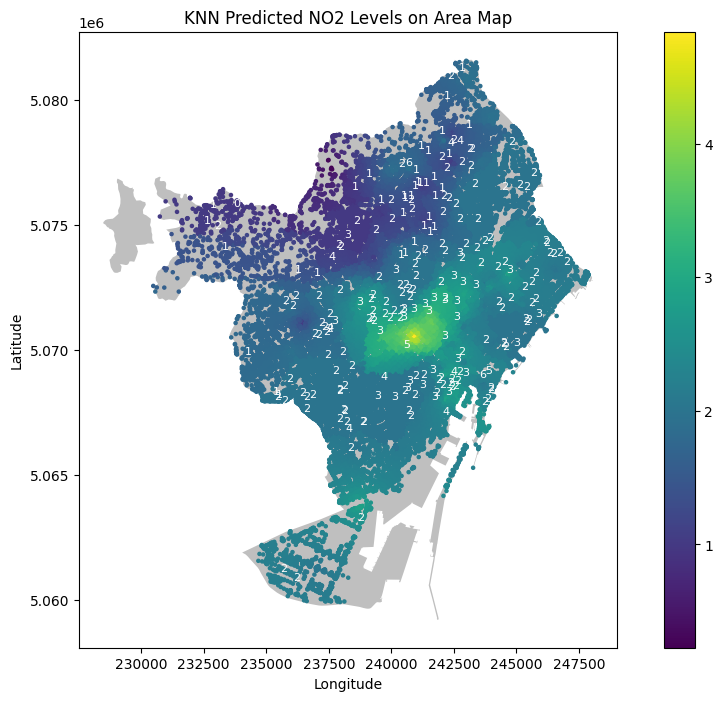

In [ ]:
# k - try to change this number and see the difference on the plot
neighbors = 5

# initialize the KNN regressor, using KNeighborsRegressor from scikit-learn
knn_regressor = KNeighborsRegressor(n_neighbors=neighbors, weights='distance')

# fit the regressor with training data, in our case, `train_coords` and `train_values`
knn_regressor.fit(train_coords, train_values)

# predict the values for the testing dataset, which are graph `nodes`
# predict method calculates the NO2 level for each point in test_coords as a weighted average
# of the NO2 levels of the 5 nearest training points, with closer points having more influence.
predicted_values_knn = knn_regressor.predict(test_coords)

# create a DataFrame with the original coordinates and the predicted values
predict_df_knn = pd.DataFrame({'Coordinate_Pair': test_coords, 'NO2_Predicted': predicted_values_knn})

# convert to gdf
predict_gdf_knn = gpd.GeoDataFrame(predict_df_knn, geometry=gpd.points_from_xy(
    [coord[0] for coord in predict_df_knn['Coordinate_Pair']],
    [coord[1] for coord in predict_df_knn['Coordinate_Pair']]
), crs=nodes.crs)

print('Have a look at the numbers that were applied in NO2_predicted; they are not classes, but continuous data.')
display(predict_gdf_knn.head())

fig, ax = plt.subplots(figsize=(12, 8))
area.plot(ax=ax, facecolor='grey', alpha=0.5)

predict_gdf_knn.plot(column='NO2_Predicted', cmap='viridis', markersize=5, ax=ax, legend=True)

# show numbers for 1.5% of the points in our dataset for better visualization
# you can manipulate numbers by changing the `sampling_fraction` parameter
sampling_fraction = 0.015
sampled_points = centroids_and_weights_gdf.sample(frac=sampling_fraction)
for idx, row in sampled_points.iterrows():
    centroid = row.centroid
    weight = row['weight']
    ax.text(centroid.x, centroid.y, f'{weight}', fontsize=8, ha='center', va='center', color='white')

ax.set_title('KNN Predicted NO2 Levels on Area Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

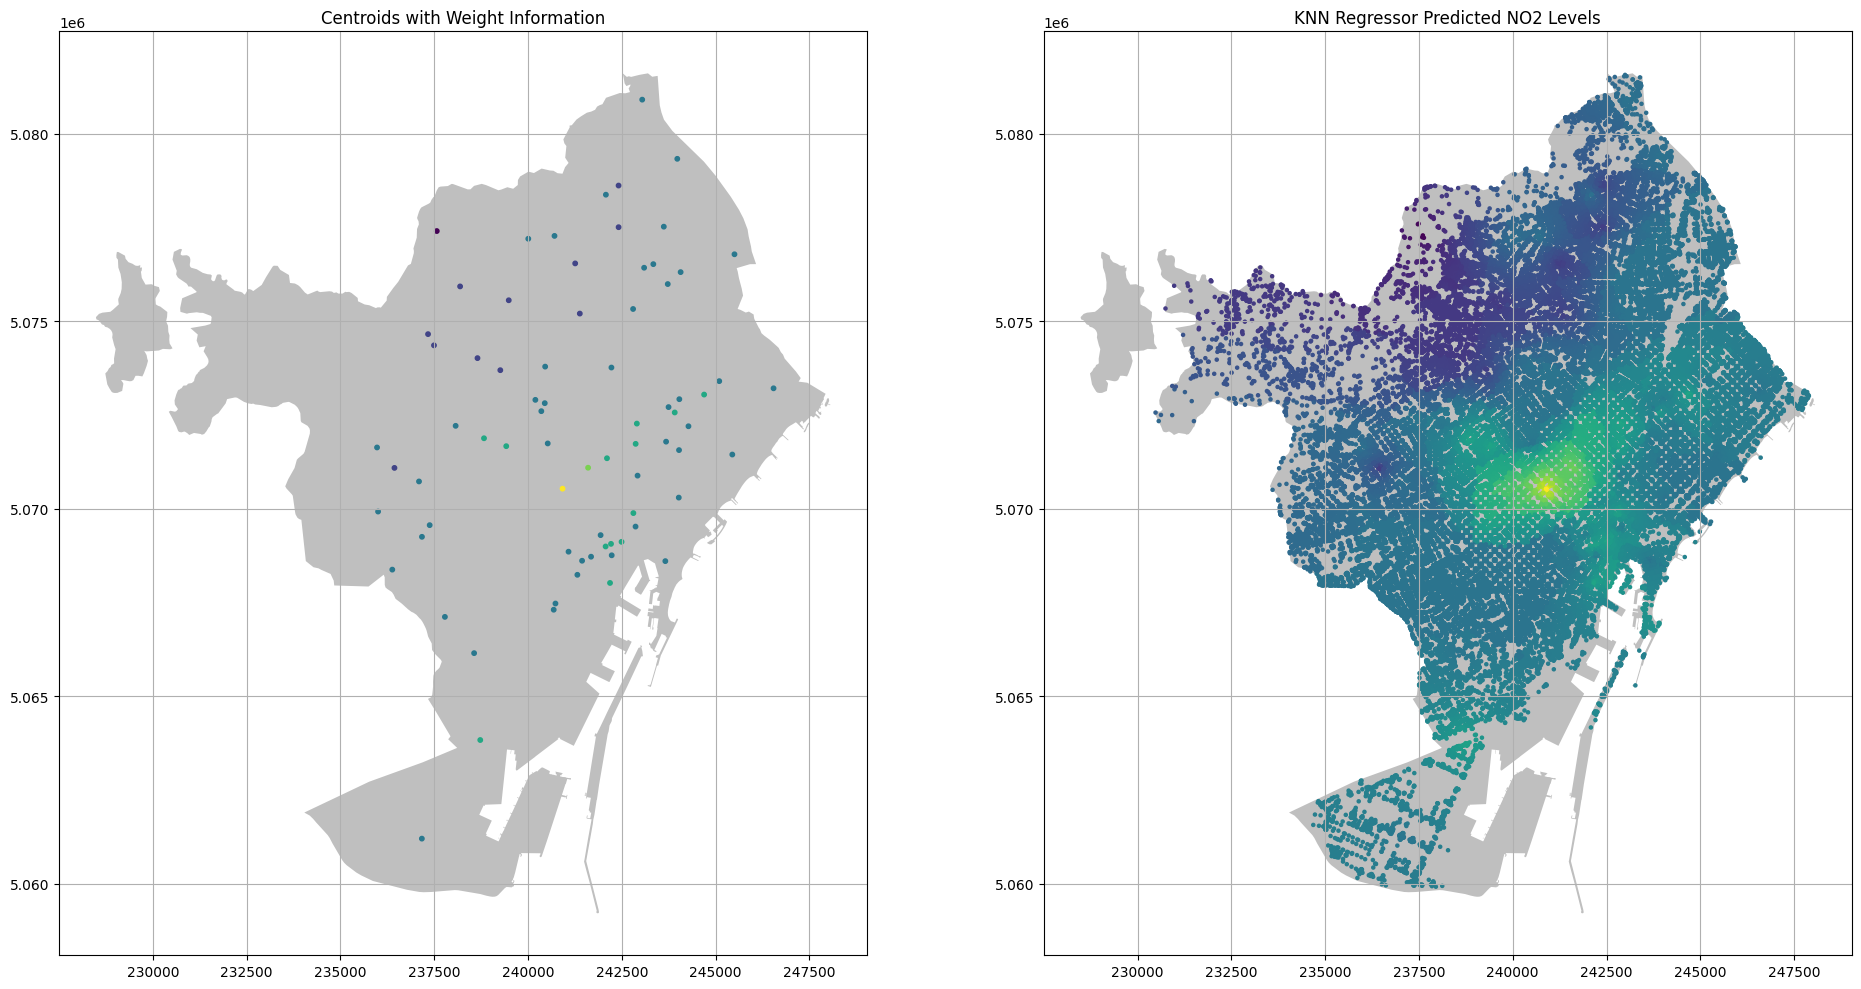

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# first plot - Centroids with Weight Information
area.plot(ax=axes[0], facecolor='grey', alpha=0.5)
centroids_and_weights_gdf_sampled.plot(
    ax=axes[0],
    column='weight',
    cmap='viridis',
    markersize=10,
    aspect='equal',
    legend=False
)
axes[0].set_title('Centroids with Weight Information')
axes[0].grid(True)

# second plot - KNN Predicted NO2 Levels on Area Map
area.plot(ax=axes[1], facecolor='grey', alpha=0.5)
predict_gdf_knn.plot(
    column='NO2_Predicted',
    cmap='viridis',
    markersize=5,
    ax=axes[1],
    legend=False
)
axes[1].set_title('KNN Regressor Predicted NO2 Levels')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Summary for KNN Regression

**Coordinates Extraction:**
- `train_coords` and `train_values` store the features (coordinates) and target values (NO2 weight) from the training dataset.
- `test_coords` extracts the coordinates from the test dataset.

**KNeighborsRegressor Initialization:**
- Initialize a `KNeighborsRegressor` instance with `n_neighbors=5` (k=5) and `weights='distance'`.
- The `weights='distance'` parameter ensures that closer neighbors have a stronger influence on the prediction.

**Model Fitting:**
- The regressor is fitted with `train_coords` as features and `train_values` as target values.

**Prediction:**
- The `predict` function is called on `test_coords`, which contains coordinates from the nodes dataset.
- For each point in `test_coords`, the regressor searches the training dataset to find the five nearest neighbors based on the geographical coordinates (latitude and longitude).
- It then uses these five neighbors' known values to predict the NO2 level of the test point.

**Creating Predicted GeoDataFrame:**
- A DataFrame (`predict_df_knn`) is created that associates each test point’s coordinates with its predicted NO2 level.
- The DataFrame is converted into a GeoDataFrame (`predict_gdf_knn`) using geopandas.

**Plotting:**
- The area map is plotted with the predicted NO2 levels using a color map (`viridis`).
- The plot includes text annotations for a sampled subset of centroids and their weights for better visualization.

**Important Points to Remember:**
- The k-NN algorithm is a lazy learner, meaning it does not build a model in advance. Instead, it uses the training data directly to predict each test point during evaluation.
- The k-NN algorithm can become slow with large datasets since it involves calculating distances for each test point across the entire training dataset.
- The `weights='distance'` parameter helps improve the predictions by giving more importance to closer neighbors, which is particularly useful in regression tasks.
